In [16]:
import fnmatch
import os.path
import json
import requests
import re
from urllib.request import urlopen, Request
import urllib.request
from bs4 import BeautifulSoup

In [17]:
import string

In [18]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /home/bvega/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bvega/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bvega/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
import pandas as pd
import math
import operator
import numpy as np
import seaborn as sns
import time

In [20]:
class Preprocessing:
    
    def tokenizarPalabras(self,texto):
        return texto.split()
    
    def removerPalabrasBasura(self,texto):
        return [i for i in texto if i not in stopwords.words('english')]
    
    def removerLetrasBasura(self,texto):
        return [i for i in texto if i not in list(string.ascii_letters)]
    
    def lemantizarPalabras(self,texto):
        return [WordNetLemmatizer().lemmatize(i, pos='v') for i in texto]

In [21]:
class JsonClass:
    
    def obtenerRutaArchivos(self,ruta):
        archivo=[]
        for roots,dirs,files in os.walk(ruta):
            for file in files:
                if fnmatch.fnmatch(file,'*.json'):
                    path = roots+"/"+file
                    archivo.append(path)
        return archivo  
    
    def leerArchivos(self,archivo):
        preprocesamiento  = Preprocessing()
        lista=()
        leer =  json.loads(open(archivo).read())  
        text=leer['body_text']
        texto=""
        for j in text:
            texto=texto+j['text']+" "
        texto  = texto.lower()
        texto  = texto.translate({ord(i): None for i in '!@#$%^&*()-_=+[{]}\|;:<,>.?/1234567890'})
        textoP = preprocesamiento.tokenizarPalabras(texto)
        textoP = preprocesamiento.removerLetrasBasura(textoP)
        textoP = preprocesamiento.removerPalabrasBasura(textoP)
        textoP = preprocesamiento.lemantizarPalabras(textoP)
        textoP = [w for w in textoP if len(w) > 2] 
        lista=(leer['paper_id'],textoP)
        texto=""
        textoP=[]
        return lista
    

In [22]:
class HtmlClass:
    
    def leerArchivosHtml(self,url):
        preprocesamiento  = Preprocessing()
        lista=()
        hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
        req = Request(url[0], headers=hdr)
        datos = urllib.request.urlopen(req).read()
        soup =  BeautifulSoup(datos,'html.parser')
        tags = soup('p')
        texto=""
        for tag in tags:
            texto=texto+tag.get_text()+" "
        texto=texto.lower()
        texto = texto.replace("’","")
        texto = texto.replace("”","")
        texto = texto.replace("“","")
        texto  = texto.translate({ord(i): None for i in '!@#$%^&*()-_=+[{]}\|;:<,>.?/1234567890'})
        textoP = preprocesamiento.tokenizarPalabras(texto)
        textoP = preprocesamiento.removerLetrasBasura(textoP)
        textoP = preprocesamiento.removerPalabrasBasura(textoP)
        textoP = preprocesamiento.lemantizarPalabras(textoP)
        textoP = [w for w in textoP if len(w) > 2]
        title=url[1]+" new"
        lista=(title,textoP)
        print("noticia procesada")
        return lista

In [23]:
class TerminoDocumento:
    
    def unirDiccionario(self,texto):
        union={}
        for i in texto:
            for j in i:
                union[j]=i[j]
        return union
    
    def obtenerPalabras(self,listaTexto):
            lista=[]
            for i in listaTexto:
                lista=lista+i
            return lista
    
    def frecuenciaPalabras(self,diccionarioTexto):
        palabrasXdocumento = {}
        for x in diccionarioTexto.values():
            for z in x:
                if z not in palabrasXdocumento.keys():
                    palabrasXdocumento[z] = 1
                else:
                    palabrasXdocumento[z] = palabrasXdocumento[z] + 1
        return palabrasXdocumento
    
    def obtenerVocabulario(self,frecuenciaTermino):
        return [(i,frecuenciaTermino[i]) for i in frecuenciaTermino if frecuenciaTermino[i]>10]
    
    def obtenerTerminoDocumento(self,frecuenciaTermino,diccionarioTexto):
        diccionarioContador={}
        for i in diccionarioTexto:
            aux={}
            aux[i]=diccionarioTexto[i]
            diccionarioContador[i]=self.frecuenciaPalabras(aux)
        diccionarioTermDoc={}
        print(diccionarioContador)
        for i in frecuenciaTermino:
            aux={}
            for j in diccionarioContador:
                if i[0] not in diccionarioContador[j].keys(): 
                    aux[j]=0
                else:
                    aux[j]=diccionarioContador[j][i[0]]
            diccionarioTermDoc[i[0]]=aux
        return diccionarioTermDoc
    
    def matrizTerminoDocumento(seflf,terminoDocumento):
        documentos=terminoDocumento[list(terminoDocumento.keys())[0]].keys()
        dframe = pd.DataFrame([key for key in documentos], columns=['Palabras'])
        for i in terminoDocumento:
            dframe[i]=[terminoDocumento[i][j] for j in terminoDocumento[i]]
        
        dframe=dframe.transpose()
        indices=list(dframe.loc['Palabras'])
        dframe.columns=indices
        dframe=dframe.drop(['Palabras'],axis=0)
        return dframe
        

In [24]:
class TfIdf:
    
    def obtenerIdf(self,terminoDocumento,lenArchivos):
        palabra=list(terminoDocumento.keys())
        idf=[]
        for i in palabra:
            count=0
            valorIdf=0
            for j in terminoDocumento[i]:
                if(terminoDocumento[i][j]!=0):
                    count+=1
            if (count!=0):
                valorIdf=math.log10(lenArchivos/count)
            else:
                valorIdf=0
            idf.append(valorIdf)
        return idf
    
    def obtenerTfIdf(self,terminoDocumentoM,idf):
        for i in terminoDocumentoM:
            terminoDocumentoM[i]=terminoDocumentoM[i]*idf
        return terminoDocumentoM

In [25]:
class SimilaridadCoseno:
    
    def obtenerSimilaridadCoseno(self,tfIdfMatriz,tfIdfHtmlMatriz):
        respaldo=pd.DataFrame(tfIdfMatriz.values,columns=tfIdfMatriz.columns)
        respaldoDos=pd.DataFrame(tfIdfHtmlMatriz.values,columns=tfIdfHtmlMatriz.columns)
        cosenoFrame=pd.DataFrame(columns=respaldo.columns)
        for i in respaldoDos:
            lista=[]
            for j in respaldo:
                dot_product = np.dot(np.array(respaldoDos[i]),np.array(respaldo[j]))
                norm_a = np.linalg.norm(np.array(respaldoDos[i]))
                norm_b = np.linalg.norm(np.array(respaldo[j])) 
                coseno=dot_product/(norm_a*norm_b)
                lista.append(coseno)
            cosenoFrame.loc[len(cosenoFrame)]=lista
        cosenoFrame=cosenoFrame.set_index(tfIdfHtmlMatriz.columns)
        return cosenoFrame

In [26]:
if __name__=="__main__":
    jsonClass         = JsonClass()
    termDoc           = TerminoDocumento()
    tfidf             = TfIdf()
    ruta="/home/bvega/Documentos/CICLO ACTUAL/COMPUTACION PARALELA/PRIMER INTERCICLO/tareas/tareaTres/train/"
    start_time=time.time()
    rutaArchivos            = jsonClass.obtenerRutaArchivos(ruta)
    listaTextos             = map(jsonClass.leerArchivos,rutaArchivos)
    listaTextos             = dict(list(listaTextos))
    
    frecuenciaTermino       = termDoc.frecuenciaPalabras(listaTextos)
    vocabulario             = termDoc.obtenerVocabulario(frecuenciaTermino)
    terminoDocumento        = termDoc.obtenerTerminoDocumento(vocabulario,listaTextos)
    matTerminoDocumento     = termDoc.matrizTerminoDocumento(terminoDocumento)
    
    matTerminoDocumento.to_csv(r'TermDocumentMatrix.csv')

    idf                     = tfidf.obtenerIdf(terminoDocumento,len(rutaArchivos))
    tfIdfMatriz             = tfidf.obtenerTfIdf(matTerminoDocumento,idf)
    print("El proceso demoro = ",(time.time()-start_time))

{'cf7ac3c62c3275108610e087a0bf0c7737c5c05d': {'march': 6, 'world': 2, 'health': 4, 'organization': 1, 'declare': 1, 'covid': 15, 'pandemic': 2, 'despite': 1, 'variation': 1, 'symptomatology': 1, 'complications': 1, 'disease': 1, 'present': 1, 'greater': 2, 'mortality': 2, 'risk': 1, 'individuals': 2, 'higher': 3, 'age': 23, 'preexist': 1, 'medical': 2, 'condition': 2, 'worst': 1, 'affect': 2, 'countries': 11, 'spike': 1, 'hospitalizations': 1, 'icu': 1, 'admissions': 1, 'deaths': 21, 'systems': 1, 'stretch': 1, 'limit': 1, 'morbidity': 1, 'impact': 3, 'virus': 1, 'attract': 1, 'considerable': 1, 'attention': 1, 'especially': 1, 'availability': 1, 'intensive': 1, 'care': 4, 'units': 1, 'exceed': 1, 'number': 4, 'case': 3, 'require': 1, 'critical': 1, 'mature': 1, 'rise': 1, 'alarm': 1, 'rate': 1, 'globally': 2, 'thirteen': 1, 'days': 1, 'later': 1, 'almost': 2, 'fivefold': 1, 'increase': 1, 'surprisingly': 1, 'much': 2, 'focus': 1, 'pattern': 2, 'thus': 1, 'far': 1, 'though': 2, 'attemp

noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
noticia procesada
{'article 1 new': {'discovery': 2, 'epitopes': 61, 'helpful': 2, 'development': 8, 'sarscov': 48, 'vaccine': 9, 'sequence': 20, 'surface': 29, 'protein': 106, 'proximal': 2, 'obtain': 7, 'blast': 2, 'whole': 3, 'genome': 4, 'genbank': 2, 'base': 8, 'ncbi': 3, 'reference': 2, 'conformational': 18, 'linear': 15, 'cell': 16, 'predict': 31, 'separately': 1, 'various': 3, 'prediction': 18, 'methods': 8, 'furthermore': 1, 'conservation': 31, 'adaptability': 2, 'evolutionary': 3, 'characteristics': 2, 'also': 6, 'analyze': 12, 'include': 5, 'one': 10, 'coincide': 4, 'epitope': 65, 'mutate': 6, 'easily': 1, 'conservative': 22, 'worth': 1, 'mention': 1, 'dominate': 2, 'absolutely': 8, 'nearly': 1, 'genomes': 22, 'deserve': 1, 'st

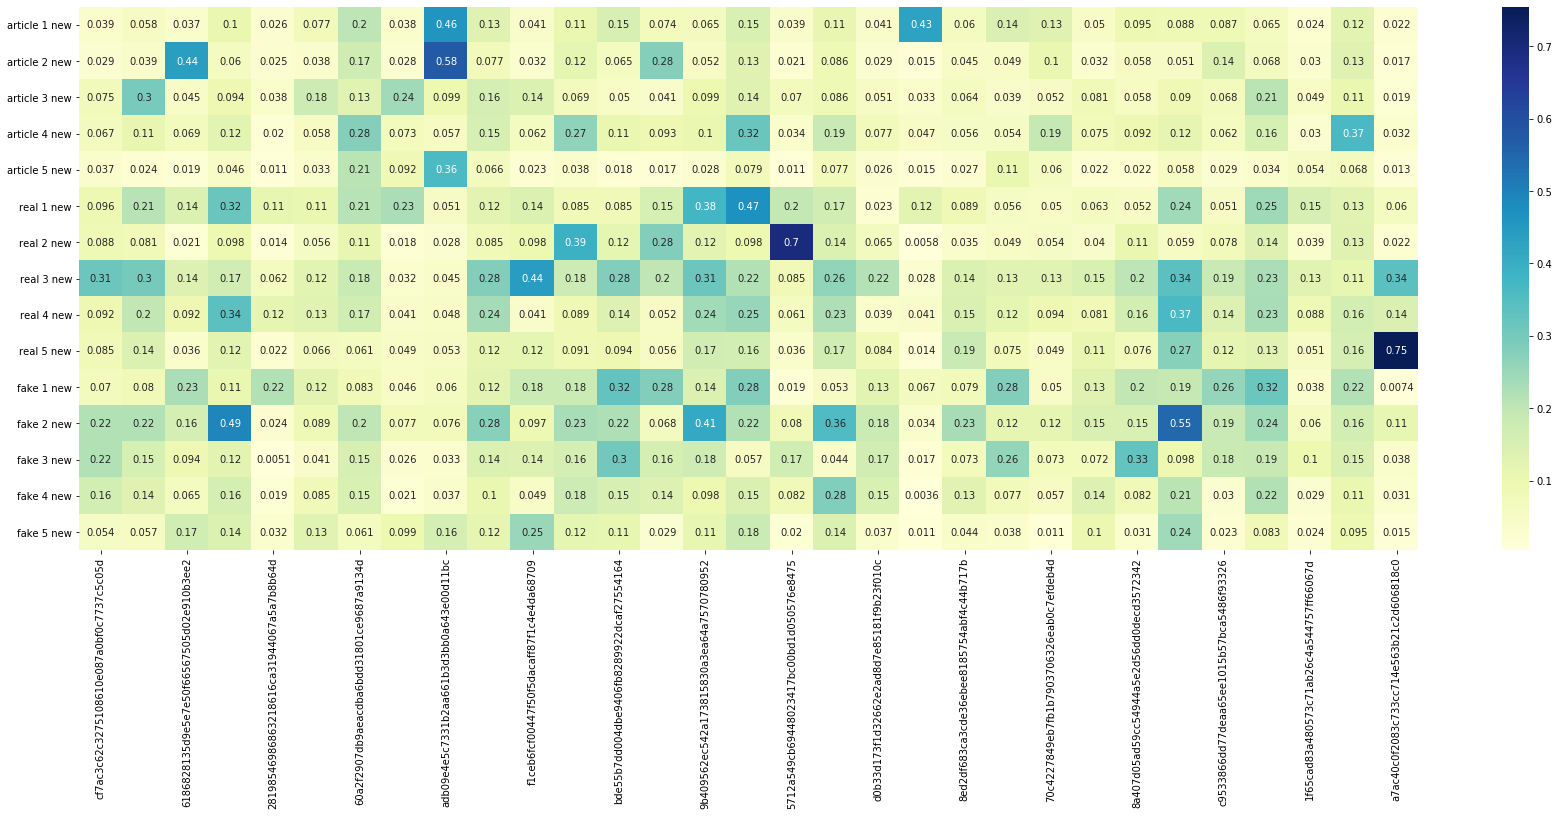

In [27]:
if __name__=="__main__":
    html              = HtmlClass()
    termDoc           = TerminoDocumento()
    tfidf             = TfIdf()
    cosenoS           = SimilaridadCoseno()
    
    lista = []
    lista.append(("https://www.biorxiv.org/content/10.1101/2020.04.03.022723v1.full","article 1"))
    lista.append(("https://www.biorxiv.org/content/10.1101/2020.02.05.936013v1.full","article 2"))
    lista.append(("https://www.biorxiv.org/content/10.1101/2020.04.10.036418v1.full","article 3"))
    lista.append(("https://www.biorxiv.org/content/10.1101/2020.04.12.025577v1.full","article 4"))
    lista.append(("https://www.biorxiv.org/content/10.1101/2020.03.03.975524v1.full","article 5"))
    lista.append(("https://www.nytimes.com/2020/05/08/health/fda-coronavirus-spit-test.html?action=click&module=Top%20Stories&pgtype=Homepage","real 1"))
    lista.append(("https://www.theguardian.com/world/2020/may/08/revealed-uk-scientists-fury-over-attempt-to-censor-covid-19-advice","real 2"))
    lista.append(("https://www.nature.com/articles/d41586-020-01284-x","real 3"))
    lista.append(("https://www.nytimes.com/2020/05/01/health/coronavirus-remdesivir.html?searchResultPosition=10","real 4"))
    lista.append(("https://theconversation.com/coronavirus-treatments-what-drugs-might-work-against-covid-19-135352","real 5"))
    lista.append(("https://bients.com/2020/04/not-china-imposes-new-coronavirus-lockdown-fears-grow-devastating-second-wave/","fake 1"))
    lista.append(("https://bients.com/2020/04/coronavirus-kill-clinicians-trace-ferocious-rampage-body-brain-toes","fake 2"))
    lista.append(("https://bients.com/2020/04/21-million-chinese-died-coronavirus-us-intelligence-officials-intercept-data","fake 3"))
    lista.append(("https://www.keyc.tv/coronavirus-and-smoking-what-does-the-world-health-organization-state","fake 4"))
    lista.append(("http://now8news.com/scientists-claim-covid-19-mutating-causing-psychosis-in-sick","fake 5"))
    
    start_time=time.time()
    listaHtml                   = map(html.leerArchivosHtml,lista)
    listaHtml                   = dict(list(listaHtml))
    
    terminoDocumentoHtml        = termDoc.obtenerTerminoDocumento(vocabulario,listaHtml)
    matTerminoDocumentoHtml     = termDoc.matrizTerminoDocumento(terminoDocumentoHtml)
    
    matTerminoDocumentoHtml.to_csv(r'TermDocumentMatrix.csv')
    
    idfHtml                     = tfidf.obtenerIdf(terminoDocumentoHtml,len(lista))
    tfIdfMatrizHtml             = tfidf.obtenerTfIdf(matTerminoDocumentoHtml,idfHtml)
    
    cosenoSimilaridadMatriz       = cosenoS.obtenerSimilaridadCoseno(tfIdfMatriz,tfIdfMatrizHtml)
    descripcionMatrizCoseno       = cosenoSimilaridadMatriz.transpose().describe()
    
    heatmap=sns.heatmap(cosenoSimilaridadMatriz,annot=True,cmap="YlGnBu")
    figure=heatmap.get_figure()
    figure.set_size_inches(30, 10)
    figure.savefig('heatmap.png', dpi=400)
    print(heatmap)
    
    matTerminoDocumentoHtml.to_csv(r'TermDocumentMatrixNews.csv')
    cosenoSimilaridadMatriz.to_csv(r'CosenoSimilarity.csv')
    descripcionMatrizCoseno.to_csv(r'DescriptionCoseno.csv')
    
    print("El proceso demoro = ",(time.time()-start_time))